In [1]:
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 36})
rc('text', usetex=True)

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import math
import functools

plt.rcParams.update({'font.size': 45})

# Objective function
def f(x):
    x1, x2 = x
    return 0.02*x1*x1 + 0.005*x2*x2

def L2(x):
    x1, x2 = x
    return math.sqrt(x1*x1 + x2*x2)

def grad1(x1):
    return 0.04*x1

def grad2(x2):
    return 0.01*x2

def grad(x):
    x1, x2 = x
    grad = np.array([0.04*x1, 0.01*x2])
    return grad

def hessian(x):
    hessian = np.array([[0.04, 0], [0, 0.01]])
    return hessian

In [2]:
# Range of time
time = int(300)

dpi=100
eps= 0.0001

# start point
p0 = [1,1,0,0]

t = np.linspace(0, time, time+1)
t2 = np.linspace(0, time, time*100+1)

In [3]:
# Calculate Nesterov's method with constant step
def Nesterov(time=time):
    Nes = np.zeros((time+1,2))
    Nes[0] = [1, 1]
    for k in range(time):
        if k==0:
            y = Nes[k]
        else:
            y = Nes[k] + (Nes[k]-Nes[k-1])* (k) / (k+3)
        Nes[k+1] = y -   grad(y)
    return Nes

Nes = Nesterov()

In [4]:
# ODE from Su et al.
def Su(p,t):
    x1, x2, dx1, dx2 = p
    dpdt = [dx1, dx2, -3*dx1/(t+eps)-grad1(x1) , -3*dx2/(t+eps)-grad2(x2)]
    return dpdt
sol1 = odeint(Su, p0, t2)

In [5]:
# ODE-C
def ODE_C_h(p,t,h=1):
    x1, x2, dx1, dx2 = p
    b = h*(t+eps+h/2)*(t+eps)/(t+eps+h)/(t+eps+h)
    dpdt = [dx1, dx2, -3*dx1/(t+eps)-grad1(x1+b*dx1) , -3*dx2/(t+eps)-grad2(x2+b*dx2)]
    return dpdt
ODE_C=functools.partial(ODE_C_h, h=1)
sol2 = odeint(ODE_C, p0, t2)

In [6]:
# ODE from Shi et al.
def Shi(p,t):
    x1, x2, dx1, dx2 = p
    dpdt = [dx1, dx2, -(3/(t+eps)+0.04)*dx1-(1+3/(2*t+2*eps))*grad1(x1) , -(3/(t+eps)+0.01)*dx2-(1+3/(2*t+2*eps))*grad2(x2)]
    return dpdt

sol3 = odeint(Shi, p0, t2)

In [7]:
#Calculate Nesterov's method (NAG-C)
def Nesterov2(time=time):
    Nes = np.zeros((time+1,2))
    Nes[0] = [1, 1]
    for k in range(time):
        if k==0:
            y = Nes[k]
        else:
            y = Nes[k] + (Nes[k]-Nes[k-1])* (2*k+2*eps+1)*(k+eps-1)*(k+eps-1) / (2*k+2*eps-1)/(k+eps+1)/(k+eps+1)
        Nes[k+1] = y -  (2*k+2*eps+1)*(2*k+2*eps+1)*grad(y)/(k+eps+1)/(k+eps+1)/4
    return Nes
Nes2 = Nesterov2()

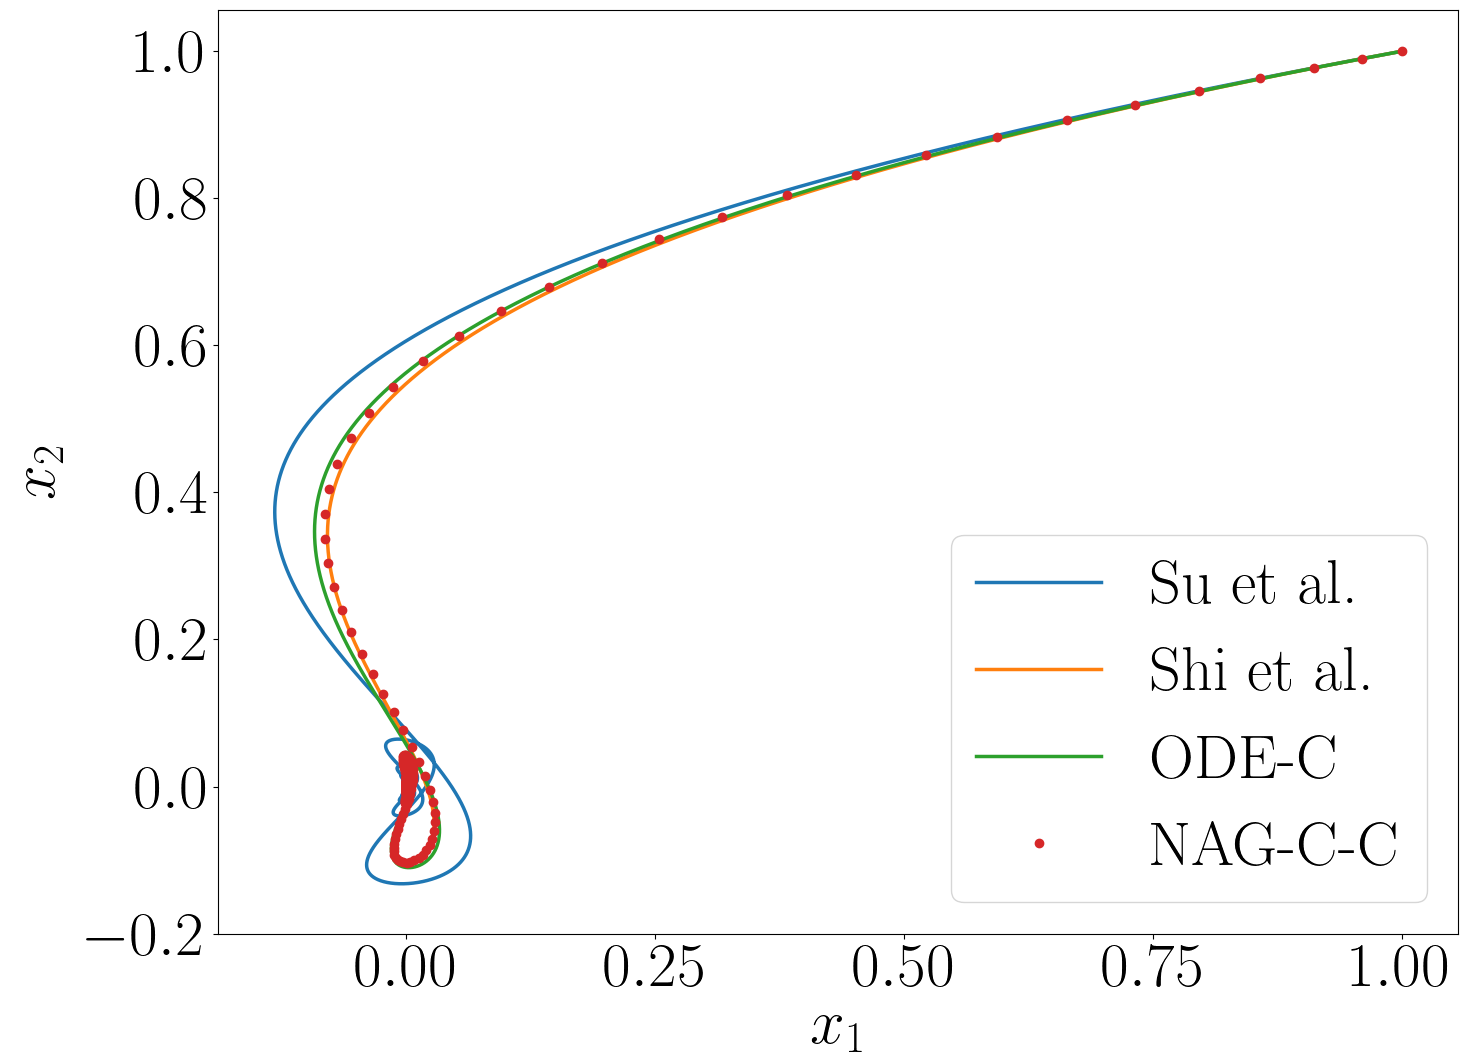

In [8]:
plt.figure(figsize=(16,12))
plt.plot(sol1[:,0], sol1[:,1], label='Su et al.', linewidth=2.5)
plt.plot(sol3[:,0], sol3[:,1], label='Shi et al.', linewidth=2.5)
plt.plot(sol2[:,0], sol2[:,1], label='ODE-C', linewidth=2.5)
plt.plot(Nes[:,0], Nes[:,1], '.', label="NAG-C-C", markersize=12)
plt.xlabel('$x_1$', labelpad=0)
plt.ylabel('$x_2$', labelpad=15)
plt.yticks([-0.2, 0.0,0.2,0.4,0.6,0.8,1.0])
plt.legend()
plt.savefig('Su-Shi-Tra-CV-C.png', dpi=dpi, bbox_inches = 'tight', pad_inches = 0)
plt.show()

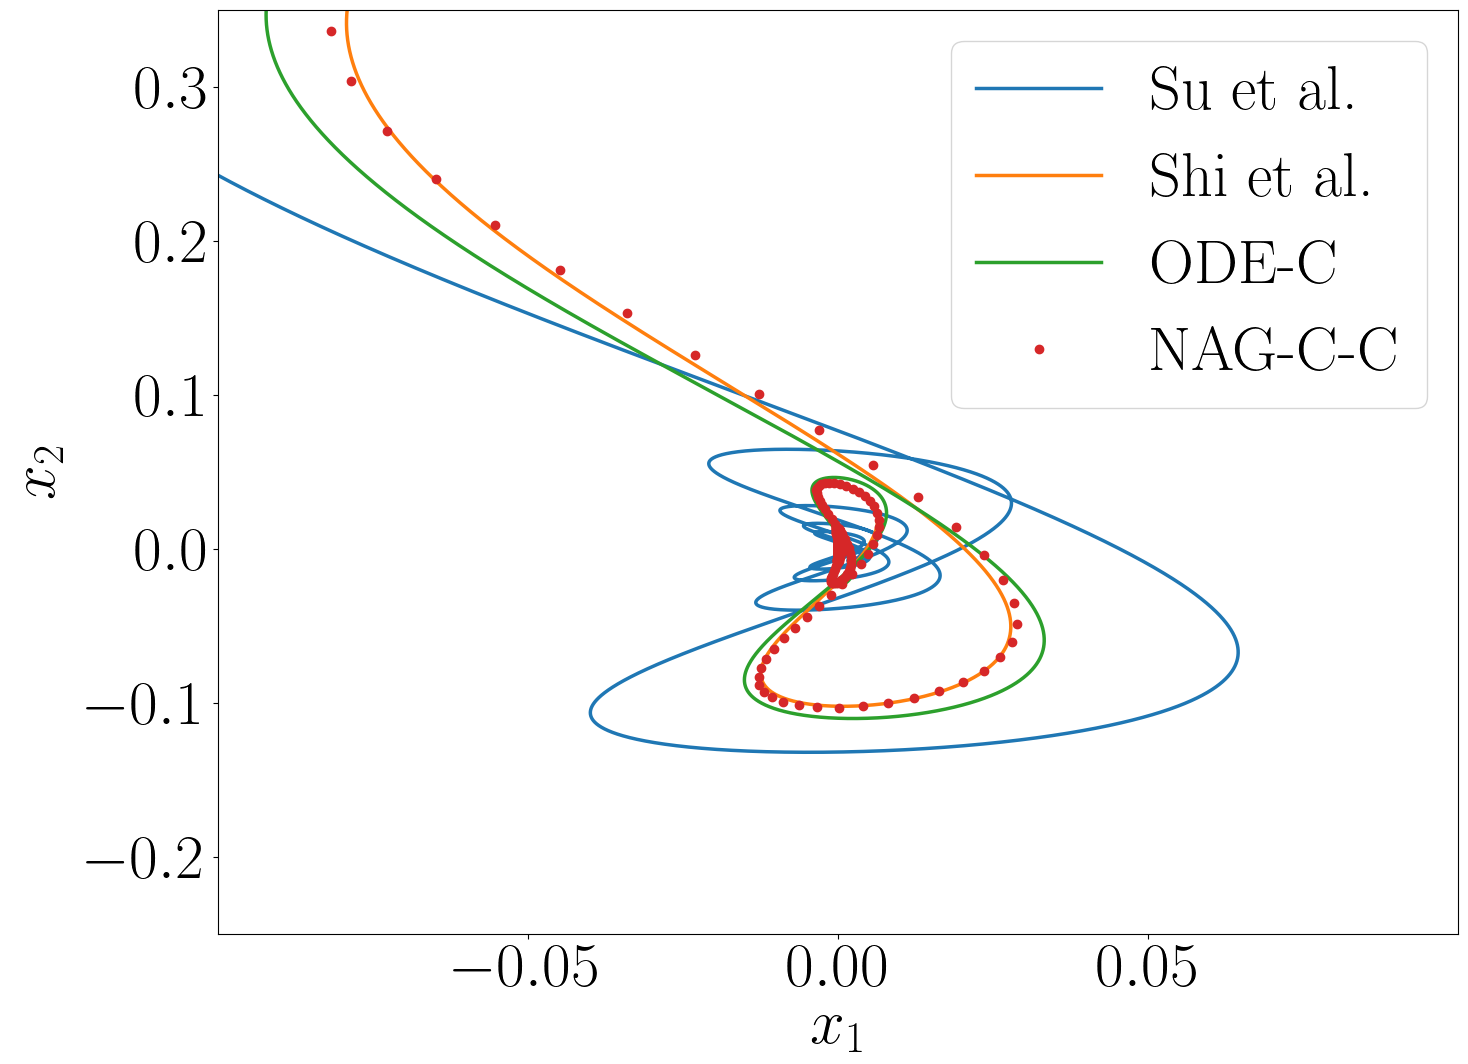

In [9]:
plt.figure(figsize=(16,12))
plt.plot(sol1[:,0], sol1[:,1], label='Su et al.', linewidth=2.5)
plt.plot(sol3[:,0], sol3[:,1], label='Shi et al.', linewidth=2.5)
plt.plot(sol2[:,0], sol2[:,1], label='ODE-C', linewidth=2.5)
plt.plot(Nes[:,0], Nes[:,1], '.', label="NAG-C-C", markersize=12)
plt.xlabel('$x_1$', labelpad=0)
plt.ylabel('$x_2$', labelpad=15)
plt.xlim(-0.1, 0.1)
plt.xticks([  -0.05, 0, 0.05])
plt.ylim(-0.25, 0.35)
plt.yticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3])
plt.legend()
plt.savefig('Su-Shi-ZTr-CV-C.png', dpi=dpi, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [10]:
sol_func = np.apply_along_axis(f, 1,  sol1[:,:2])
sol2_func = np.apply_along_axis(f, 1, sol2[:,:2])
sol3_func = np.apply_along_axis(f, 1, sol3[:,:2])
Nes_func = np.apply_along_axis(f, 1, Nes)
Nes2_func = np.apply_along_axis(f, 1, Nes2)

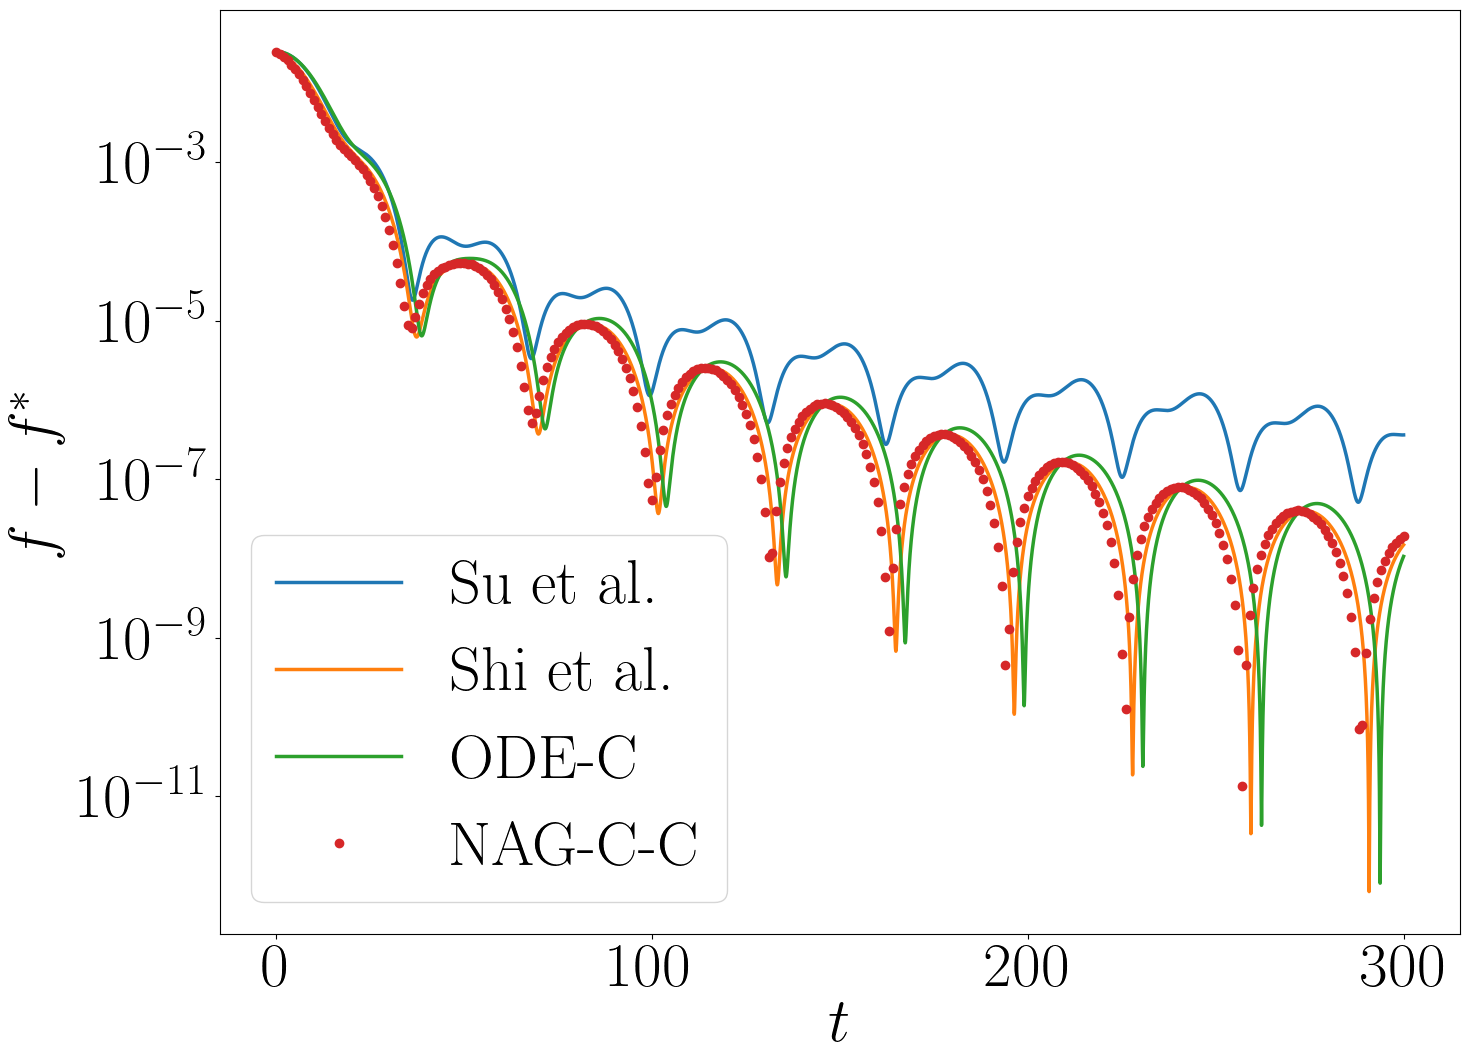

In [11]:
plt.figure(figsize=(16,12))
plt.plot(t2, sol_func, label='Su et al.', linewidth=2.5)
plt.plot(t2, sol3_func, label='Shi et al.', linewidth=2.5)
plt.plot(t2, sol2_func, label='ODE-C', linewidth=2.5)
plt.plot(t, Nes_func, '.', label="NAG-C-C", markersize=12)
plt.xlabel('$t$', labelpad=0)
plt.ylabel('$f-f^*$', labelpad=10)
plt.yscale('log')
plt.legend()
plt.savefig('Su-Shi-Errors-CV-C.png', dpi=dpi, bbox_inches = 'tight', pad_inches = 0)
plt.show()

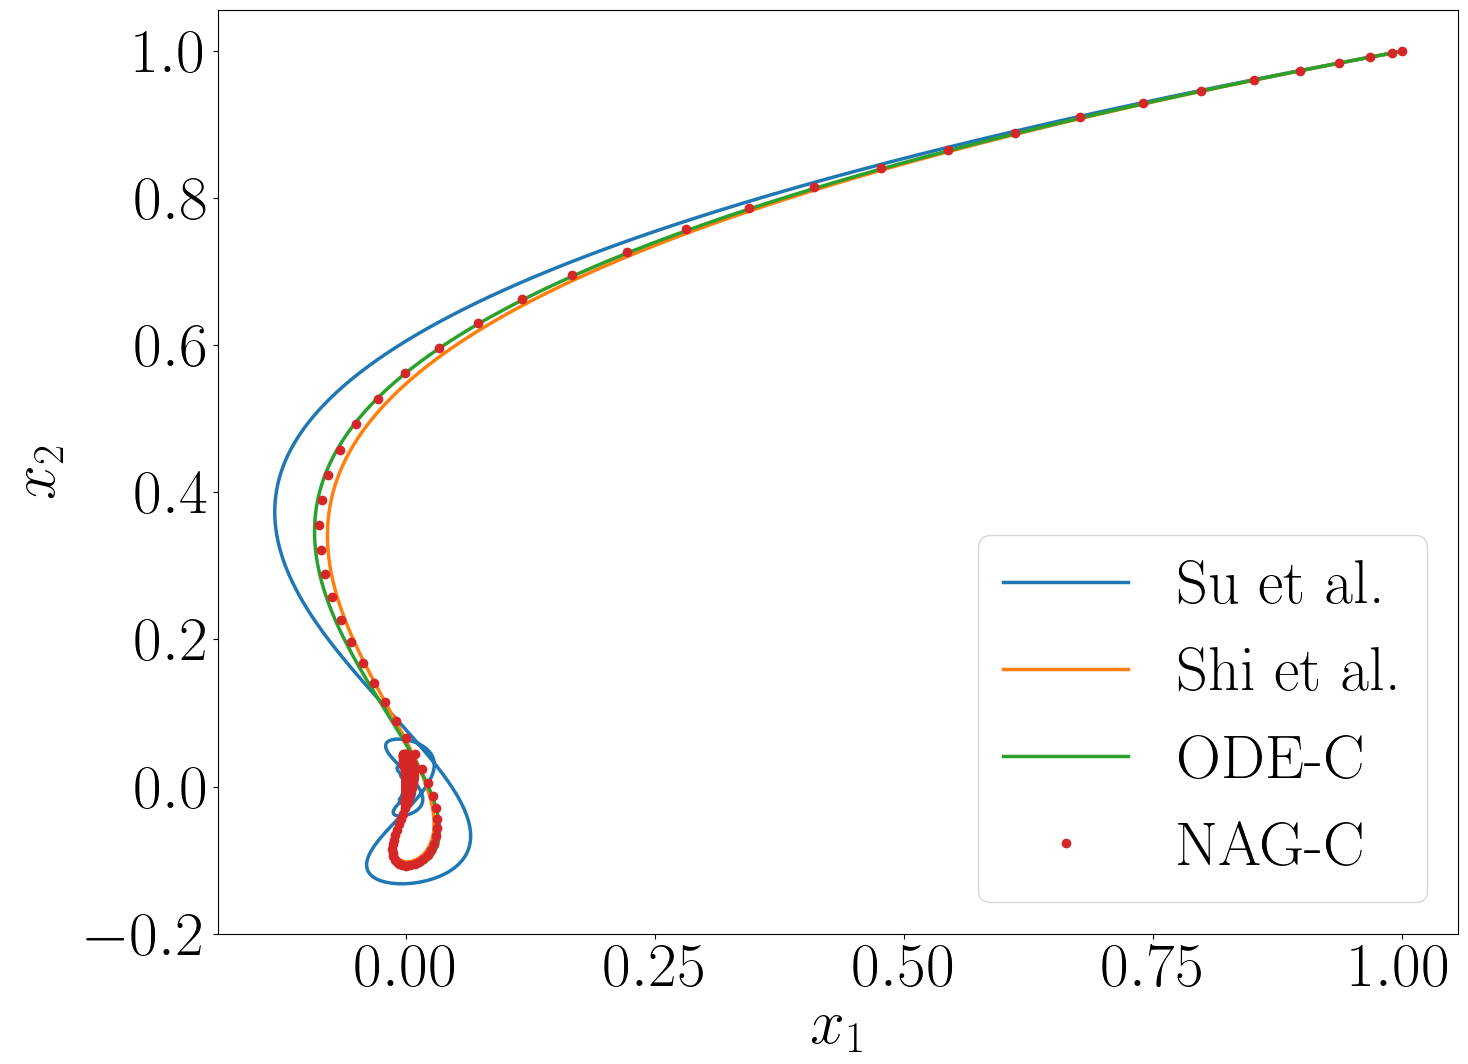

In [12]:
plt.figure(figsize=(16,12))
plt.plot(sol1[:,0], sol1[:,1], label='Su et al.', linewidth=2.5)
plt.plot(sol3[:,0], sol3[:,1], label='Shi et al.', linewidth=2.5)
plt.plot(sol2[:,0], sol2[:,1], label='ODE-C', linewidth=2.5)
plt.plot(Nes2[:,0], Nes2[:,1], '.', label="NAG-C", markersize=12)
plt.xlabel('$x_1$', labelpad=0)
plt.ylabel('$x_2$', labelpad=15)
plt.yticks([-0.2, 0.0,0.2,0.4,0.6,0.8,1.0])
plt.legend()
plt.savefig('Su-Shi-Tra-CV.png', dpi=dpi, bbox_inches = 'tight', pad_inches = 0)
plt.show()

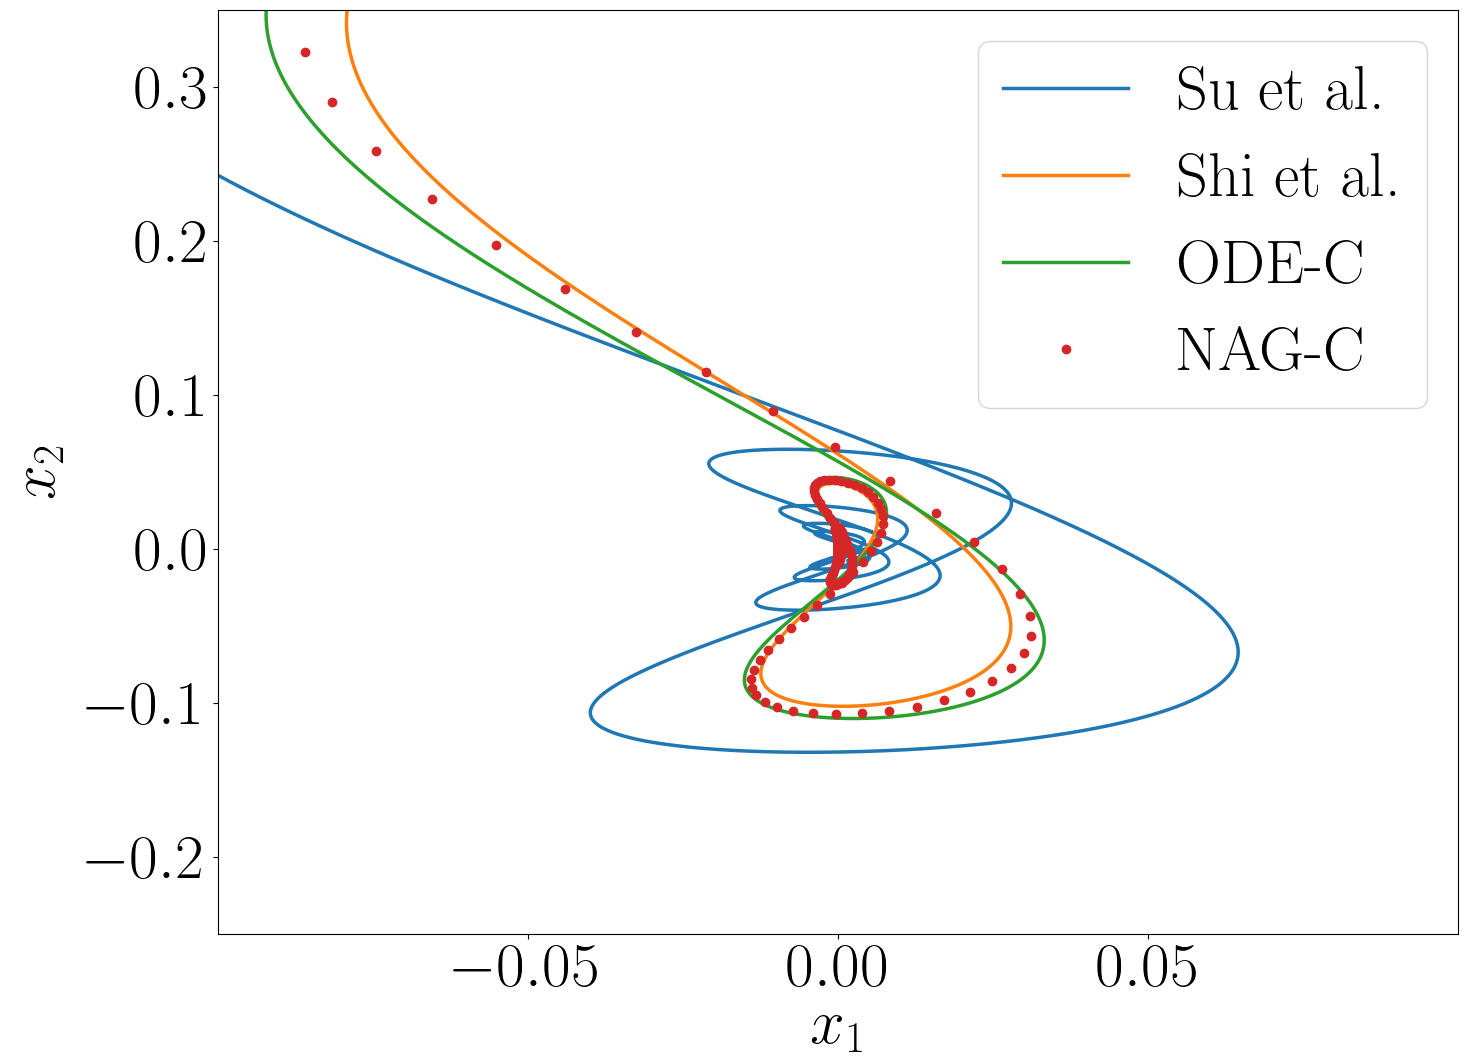

In [13]:
plt.figure(figsize=(16,12))
plt.plot(sol1[:,0], sol1[:,1], label='Su et al.', linewidth=2.5)
plt.plot(sol3[:,0], sol3[:,1], label='Shi et al.', linewidth=2.5)
plt.plot(sol2[:,0], sol2[:,1], label='ODE-C', linewidth=2.5)
plt.plot(Nes2[:,0], Nes2[:,1], '.', label="NAG-C", markersize=12)
plt.xlabel('$x_1$', labelpad=0)
plt.ylabel('$x_2$', labelpad=15)
plt.xlim(-0.1, 0.1)
plt.xticks([  -0.05, 0, 0.05])
plt.ylim(-0.25, 0.35)
plt.yticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3])
plt.legend()
plt.savefig('Su-Shi-ZTr-CV.png', dpi=dpi, bbox_inches = 'tight', pad_inches = 0)
plt.show()

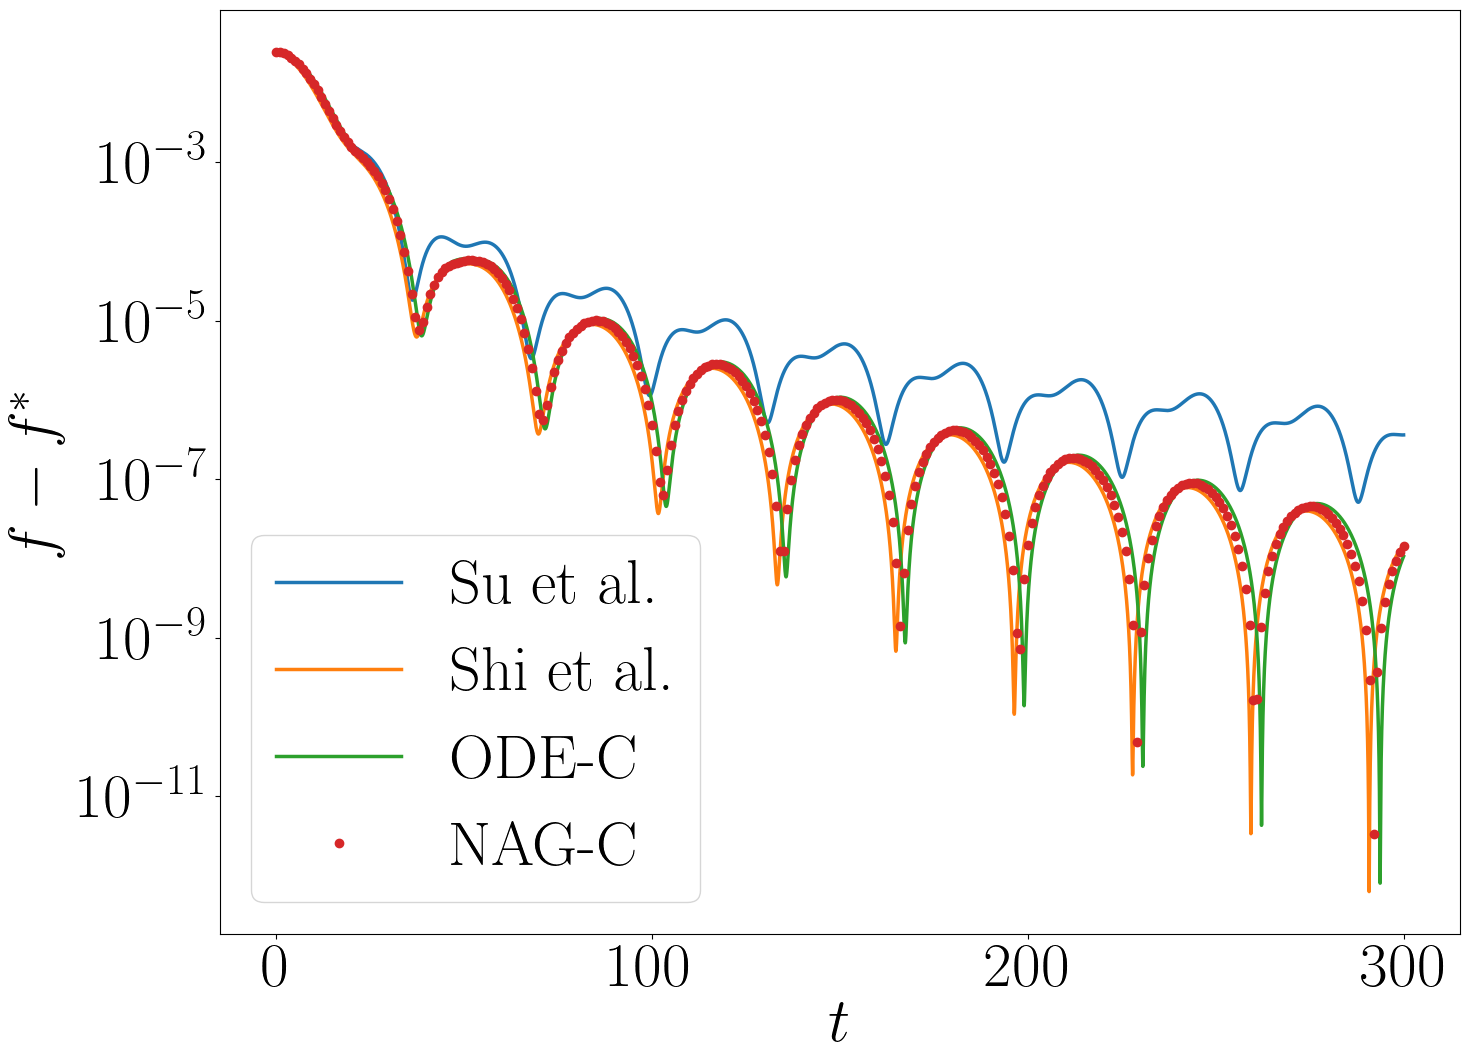

In [14]:
plt.figure(figsize=(16,12))
plt.plot(t2, sol_func, label='Su et al.', linewidth=2.5)
plt.plot(t2, sol3_func, label='Shi et al.', linewidth=2.5)
plt.plot(t2, sol2_func, label='ODE-C', linewidth=2.5)
plt.plot(t, Nes2_func, '.', label="NAG-C", markersize=12)
plt.xlabel('$t$', labelpad=0)
plt.ylabel('$f-f^*$', labelpad=10)
plt.yscale('log')
plt.legend()
plt.savefig('Su-Shi-Errors-CV.png', dpi=dpi, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [15]:
sol1h = sol1[:,:2][np.arange(0,len(sol1[:,:2]),100)]
sol2h = sol2[:,:2][np.arange(0,len(sol2[:,:2]),100)]
sol3h = sol3[:,:2][np.arange(0,len(sol3[:,:2]),100)]

L2_ODE_Nes = np.apply_along_axis(L2, 1, sol2h[:,:2]-Nes)
L2_shi_Nes = np.apply_along_axis(L2, 1, sol3h[:,:2]-Nes)
L2_su_Nes = np.apply_along_axis(L2, 1, sol1h[:,:2]-Nes)
L2_ODE_Nes2 = np.apply_along_axis(L2, 1, sol2h[:,:2]-Nes2)
L2_shi_Nes2 = np.apply_along_axis(L2, 1, sol3h[:,:2]-Nes2)
L2_su_Nes2 = np.apply_along_axis(L2, 1, sol1h[:,:2]-Nes2)

In [16]:
def up_mean(arr):
    return np.mean(arr[100:])

In [17]:
# Calculate mean error between ODE and NAG
print(up_mean(L2_ODE_Nes))
print(up_mean(L2_shi_Nes))
print(up_mean(L2_su_Nes))
print(up_mean(L2_ODE_Nes2))
print(up_mean(L2_shi_Nes2))
print(up_mean(L2_su_Nes2))

0.0029580290632908635
0.0011952181835586048
0.00960325400299845
0.0009433498482816378
0.0008633222474260772
0.009010159859248879


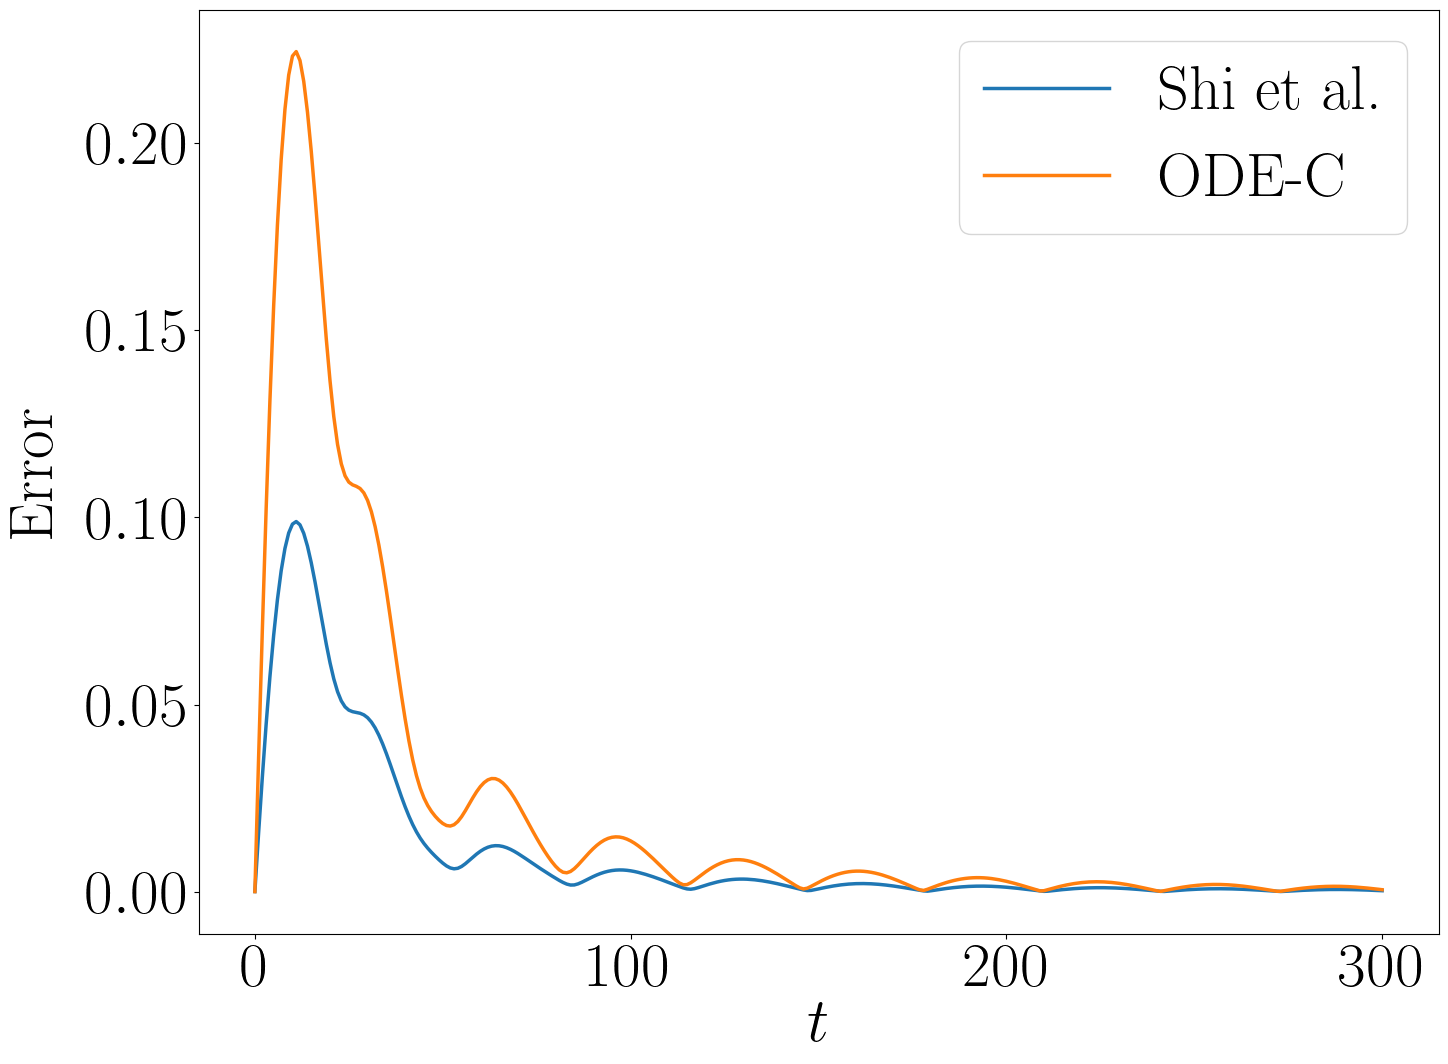

In [18]:
plt.rcParams.update({'font.size': 45})
plt.figure(figsize=(16,12))
plt.plot(t[:], L2_shi_Nes[:], label='Shi et al.', linewidth=2.5)

plt.plot(t[:], L2_ODE_Nes[:], label='ODE-C', linewidth=2.5)
plt.xlabel('$t$', labelpad=0)
plt.ylabel('Error', labelpad=15)
plt.legend()
plt.savefig('Shi-L2-CV-C.png', dpi=dpi, bbox_inches = 'tight', pad_inches = 0)
plt.show()

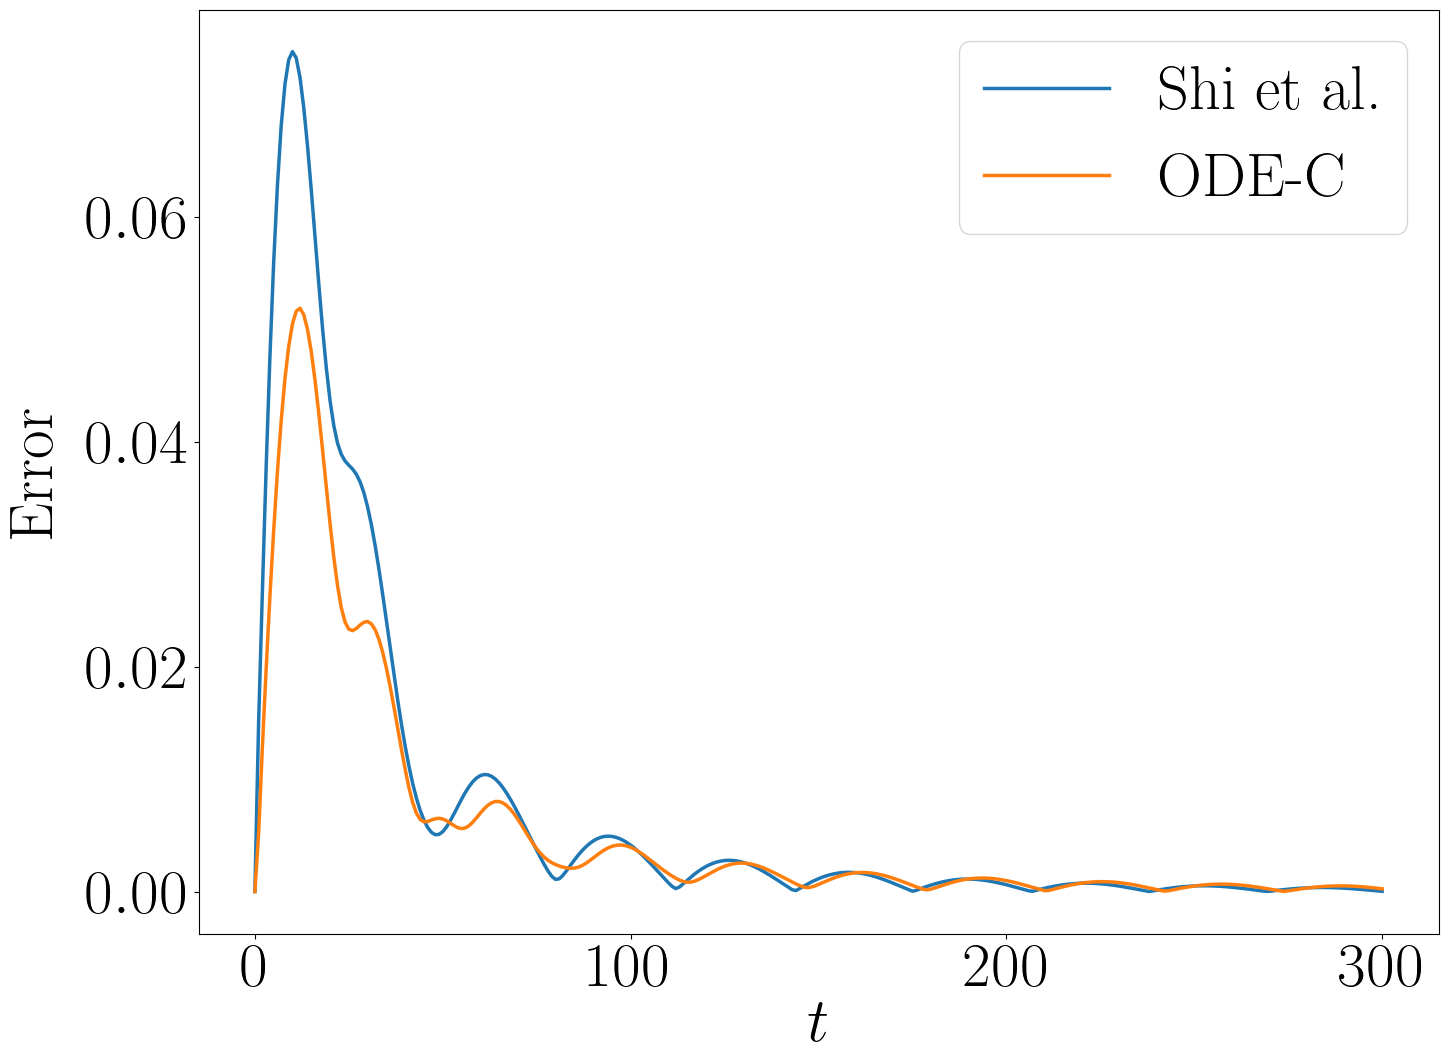

In [19]:
plt.rcParams.update({'font.size': 45})
plt.figure(figsize=(16,12))

plt.plot(t[:], L2_shi_Nes2[:], label='Shi et al.', linewidth=2.5)
plt.plot(t[:], L2_ODE_Nes2[:], label='ODE-C', linewidth=2.5)
plt.xlabel('$t$', labelpad=0)
plt.ylabel('Error', labelpad=15)
plt.legend()
plt.savefig('Shi-L2-CV.png', dpi=dpi, bbox_inches = 'tight', pad_inches = 0)
plt.show()